Data manipulation for Ciofani 16hr timestamp samples

In [46]:
import glob
import re
import pandas as pd

def get_files(directory, ext):
    #item = ['Treg','rep_GSM1004873','rep_GSM1004871','rep_GSM1004872','rep_GSM1004936','rep_GSM1004937','rep_GSM1004868','09h','12h','24h','48h']
    return [f for f in glob.glob(directory + '/' +  '*' + ext) if '16h' in f]

factor_files = {
    'Th17.Bulk.16h': get_files('/data/reddylab/Alex/collab/20200819_Keith//processing/rna_seq/ciofani_rnaseq_2012-se-unstranded-with-sjdb', '.featurecounts.counts.txt')
}

def clean_count_column(s):
    return '.'.join(s.split('/')[-1].replace('.rnaseq', '.Bulk').split('.')[:4])


for factor, files in factor_files.items():
    df = None
    for f in files:
        df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')
        df.rename(columns = {
            'Th17.Bulk.16h.rep_GSM1004935':'Th17.Bulk.16h.rep1',
            'Th17.Bulk.16h.rep_GSM1004936':'Th17.Bulk.16h.rep2',
            'Th17.Bulk.16h.rep_GSM1004937':'Th17.Bulk.16h.rep3',
            'Th0.Bulk.16h.rep_GSM1004870':'Th0.Bulk.16h.rep1',
            'Th0.Bulk.16h.rep_GSM1004871':'Th0.Bulk.16h.rep2',
            'Th0.Bulk.16h.rep_GSM1004872':'Th0.Bulk.16h.rep3'}, inplace = True)

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')

    df.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/%s.counts.txt' % factor, sep='\t')



Data manipulation for Ciofani 48hr timestamp samples

In [7]:
import glob
import re
import pandas as pd

def get_files(directory, ext):
    #item = ['Treg','rep_GSM1004873','rep_GSM1004871','rep_GSM1004872','rep_GSM1004936','rep_GSM1004937','rep_GSM1004868','09h','12h','24h','48h']
    return [f for f in glob.glob(directory + '/' +  '*' + ext) if '48h' in f]

factor_files = {
    'Th17.Bulk.48h': get_files('/data/reddylab/Alex/collab/20200819_Keith/processing/rna_seq/ciofani_rnaseq_2012.extra_set1-se-unstranded-with-sjdb', '.featurecounts.counts.txt')
}

def clean_count_column(s):
    if 'B-ATF_wt' in s:
        return '.'.join(s.split('/')[-1].replace('.rnaseq.B-ATF_wt', '.Bulk').split('.')[:4])
    elif 'IRF4_wt' in s:
        return '.'.join(s.split('/')[-1].replace('.rnaseq.IRF4_wt', '.Bulk').split('.')[:4])
    else:
        return '.'.join(s.split('/')[-1].replace('.rnaseq.wt', '.Bulk').split('.')[:4])

for factor, files in factor_files.items():
    df = None
    for f in files:
        df_tmp = pd.read_csv(f, sep='\t', skiprows=1, index_col=0)
        df_tmp.columns = df_tmp.columns[:-1].tolist() + [clean_count_column(f)]
        if df is None:
            df = df_tmp.loc[:, ['Chr', 'Start', 'End'] + [df_tmp.columns[-1]]]
        else:
            df = df.join(df_tmp.loc[:, df_tmp.columns[-1]], how='right')
        df.rename(columns = {
            'Th17.Bulk.48h.rep_GSM1004966':'Th17.Bulk.48h.rep1',
            'Th17.Bulk.48h.rep_GSM1004973':'Th17.Bulk.48h.rep2',
            'Th17.Bulk.48h.rep_GSM1004958':'Th17.Bulk.48h.rep3',
            'Th17.Bulk.48h.rep_GSM1004968':'Th17.Bulk.48h.rep4',
            'Th17.Bulk.48h.rep_GSM1004960':'Th17.Bulk.48h.rep5',
            'Th0.Bulk.48h.rep_GSM1004887':'Th0.Bulk.48h.rep1',
            'Th0.Bulk.48h.rep_GSM1004897':'Th0.Bulk.48h.rep2'}, inplace = True)

    count_columns = ["rep" in c for c in df.columns]
    df.loc[:, count_columns] = df.loc[:, count_columns].astype(dtype='int')

    df.to_csv('/data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/%s.counts.txt' % factor, sep='\t')

In [20]:
%%bash
mkdir -p /data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2
source /data/reddylab/software/miniconda3/bin/activate alex_py3
sbatch -pnew,all \
    --array=0-2 \
    --mem 16G \
    -o /data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2.%a.out \
    <<'EOF'
#!/bin/bash
COMPARISONS=( \
     Th17.Bulk.16h-Th0.Bulk.16h \
     Th17.Bulk.48h-Th0.Bulk.48h \ 
)

COMPARISON=${COMPARISONS[${SLURM_ARRAY_TASK_ID}]}
TREAT=$(echo $COMPARISON | cut -d"-" -f1)
CONTROL=$(echo $COMPARISON | cut -d"-" -f2)
FACTOR=$(echo $COMPARISON | cut -d"-" -f1)
Rscript /data/reddylab/Revathy/dev/scripts/rnaseq_dge.deseq2_v2.R \
    --treatments $(echo ${TREAT}.rep{1,2,3,4,5}) \
    --controls $(echo ${CONTROL}.rep{1,2}) \
    --lfcShrink ashr \
    --counts-skip-ncols 3 \
    --outdir /data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2 \
    --counts /data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/${FACTOR}.counts.txt
EOF


Submitted batch job 22955449


In [21]:
%%bash
FDR=0.05
COMPARISONS=( \ 
     
     Th17.Bulk.16h_vs_Th0.Bulk.16h \
     Th17.Bulk.48h_vs_Th0.Bulk.48h \
    
)
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.txt |  cut -d. -f1 > ${COMP}.expressed_genes.txt 
    
    # Save significant upreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3>0)){print $1}}' |  cut -d. -f1 > ${COMP}.upreg_genes.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.txt |  awk -vFDR=${FDR} '{if(($NF<FDR) && ($3<0)){print $1}}' |  cut -d. -f1 > ${COMP}.downreg_genes.txt 

done

In [22]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2
for ii in $(/bin/ls -1 *_vs_*h.txt | /bin/grep -v with_genes);
do
    python /data/reddylab/Alex/collab/20180628_Layden/processing/rna_seq/scripts/mm10.rnaseq_dge_deseq2.add_gene_names.py \
        ${ii} \
        ${ii/.txt/.with_genes.txt}
done

In [23]:
%%bash
FDR=0.05
COMPARISONS=( \
     Th17.Bulk.16h_vs_Th0.Bulk.16h \
     Th17.Bulk.48h_vs_Th0.Bulk.48h \
)
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2
for COMP in ${COMPARISONS[@]};
do
    # Save expressed genes (more than 5 normalized counts)
    tail -n+2 ${COMP}.with_genes.txt |  awk '{print $NF}' > ${COMP}.expressed_genes.symbols.txt 

    # Save significant upreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3>0)){print $NF}}' > ${COMP}.upreg_genes.symbols.txt 

    # Save significant downreg genes
    tail -n+2 ${COMP}.with_genes.txt |  awk -vFDR=${FDR} '{if(($(NF-1)<FDR) && ($3<0)){print $NF}}' > ${COMP}.downreg_genes.symbols.txt 

done

Convert pdf into png

In [24]:
%%bash
source /data/reddylab/software/miniconda3/bin/activate alex_py3
cd /data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2
module load ImageMagick/7.0.1-gcb01
for ii in $(/bin/ls -1 *.pdf);
do
    convert ${ii} ${ii/.pdf/.png}
done

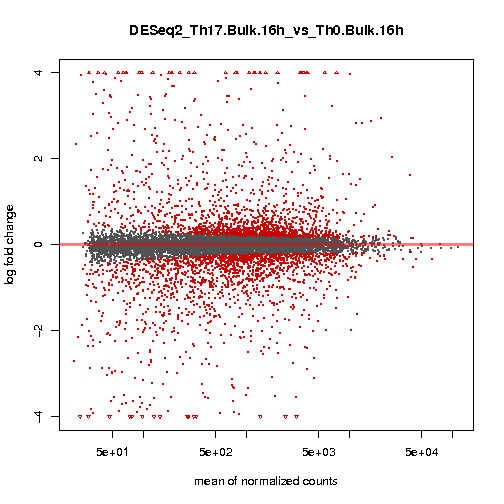

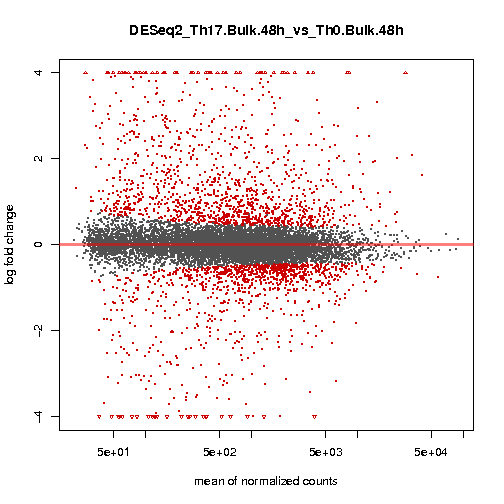

In [25]:
from IPython.display import display, Image
COMPARISONS=[
    'Th17.Bulk.16h_vs_Th0.Bulk.16h',
    'Th17.Bulk.48h_vs_Th0.Bulk.48h'
    ]
for c in COMPARISONS:
    display(Image("/data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2/%s.png" % c))

====== Th17.Bulk.16h_vs_Th0.Bulk.16h ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000041782.14,3055.036712,-4.180262,0.141912,6.616576e-192,6.965269e-188,Lad1,protein_coding
1,ENSMUSG00000017493.12,10307.459260,3.964582,0.134748,2.294445e-191,1.207681e-187,Igfbp4,protein_coding
2,ENSMUSG00000020841.5,20601.337502,2.962606,0.102619,2.431723e-184,8.532918e-181,Cpd,protein_coding
3,ENSMUSG00000076617.9,3036.676504,-3.530240,0.126966,3.882308e-171,1.021726e-167,Ighm,IG_C_gene
4,ENSMUSG00000034028.15,1362.524234,-5.242231,0.191171,2.247143e-167,4.731134e-164,Cd226,protein_coding
5,ENSMUSG00000019256.17,3905.820685,4.306279,0.157862,4.163564e-165,7.304973e-162,Ahr,protein_coding
6,ENSMUSG00000028150.14,3329.794203,4.244101,0.156266,1.161250e-163,1.746354e-160,Rorc,protein_coding
7,ENSMUSG00000030263.13,4527.026505,-3.097285,0.114894,4.298174e-161,5.655859e-158,Lrmp,protein_coding
8,ENSMUSG00000032688.7,16233.921185,2.872677,0.116570,3.466767e-135,4.054962e-132,Malt1,protein_coding
9,ENSMUSG00000004837.2,2834.020140,-2.747495,0.111952,3.890437e-134,4.095463e-131,Grap,protein_coding


====== Th17.Bulk.48h_vs_Th0.Bulk.48h ======


,Unnamed: 0,baseMean,log2FoldChange,lfcSE,pvalue,padj,GeneName,GeneType
0,ENSMUSG00000037820.15,3837.681083,5.790356,0.279758,6.968564e-98,7.899564e-94,Tgm2,protein_coding
1,ENSMUSG00000090698.2,1348.870750,6.583244,0.341268,1.008166e-85,5.714283e-82,Apold1,protein_coding
2,ENSMUSG00000018341.12,1975.915540,5.585961,0.302192,5.927715e-79,2.239886e-75,Il12rb2,protein_coding
3,ENSMUSG00000024424.14,1196.913902,6.090505,0.336600,5.946317e-76,1.685186e-72,Ttc39c,protein_coding
4,ENSMUSG00000025348.9,1209.318647,5.636353,0.326751,2.349859e-69,5.327599e-66,Itga7,protein_coding
5,ENSMUSG00000053113.3,1628.543733,5.243704,0.328132,5.030493e-60,9.504278e-57,Socs3,protein_coding
6,ENSMUSG00000035105.5,8364.247113,4.184094,0.261110,1.224443e-59,1.982898e-56,Egln3,protein_coding
7,ENSMUSG00000045573.9,634.853661,-8.496905,0.534695,3.045109e-59,4.314920e-56,Penk,protein_coding
8,ENSMUSG00000046794.9,2563.081063,4.205508,0.275709,2.122057e-54,2.672849e-51,Ppp1r3b,protein_coding
9,ENSMUSG00000033826.9,784.839245,4.881083,0.336052,3.722616e-50,4.219958e-47,Dnah8,protein_coding


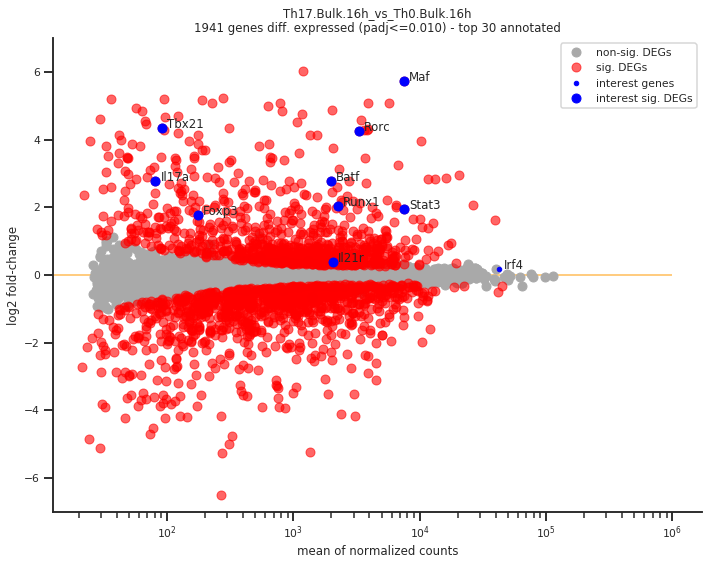

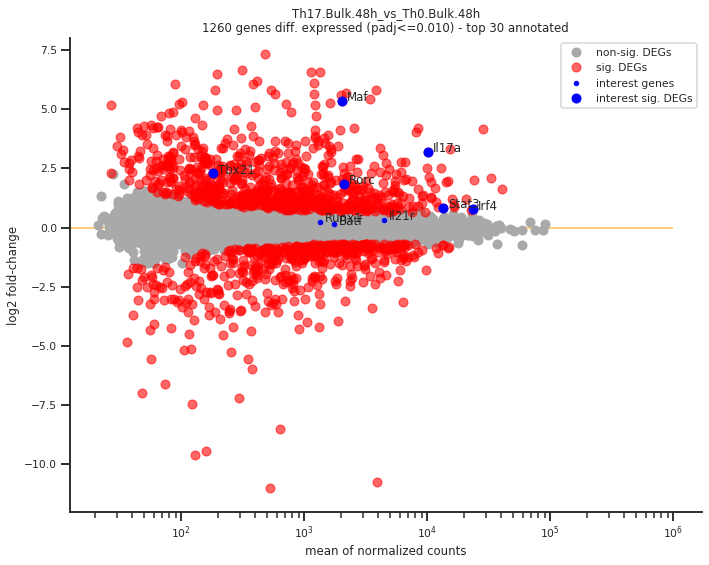

In [3]:
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk", font_scale=0.65)
sns.set_style("whitegrid")
plt.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Config
pval_thres = 0.01
top_to_report = 30

special_genes = ['Maf', 'Il17a', 'Rorc', 'Stat3', 'Stat5', 'Batf', 'Irf4', 'Runx1', 'Il21r', 'Tbx21', 'Foxp3']
comparisons = [
    'Th17.Bulk.16h_vs_Th0.Bulk.16h',
    'Th17.Bulk.48h_vs_Th0.Bulk.48h' 
]

data_dir = '/data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/differential_testing/deseq2'

for comparison in comparisons:
    df = pd.read_csv("%s/%s.with_genes.txt" % (data_dir, comparison),
                    sep="\t")
#     df_gene_name_type = pd.read_csv("/data/reddylab/Reference_Data/Refseq/GRCh38/GRCh38_latest_genomic.gene_name_gene_type.txt",
#                     sep="\t",
#                     names=['GeneName', 'GeneType'])
#     df = df.merge(df_gene_name_type, on='GeneName')
#     pseudogene_types = set(df.loc[["pseudogene" in gt for gt in df['GeneType'].values], 'GeneType'].values)
#     df = df[~df.GeneType.isin(pseudogene_types)]
#     df = df[df.GeneType.isin(['protein_coding'])]
    fig = plt.figure(figsize=(10,8))
    ax = plt.subplot(1, 1, 1)
    df_non_sig = df[~(df.padj<pval_thres) & (~df.GeneName.isin(special_genes))]
    ax.set_xscale('log')
    ax.plot(df_non_sig['baseMean'].values, 
            df_non_sig['log2FoldChange'].values, 
            'o', color='darkgrey', label='non-sig. DEGs')

    ylims = [np.ceil(df['log2FoldChange'].min()-1), 
             np.floor(df['log2FoldChange'].max()+1)]
    df_sig = df[df.padj<=pval_thres]
    ax.plot(df_sig['baseMean'].values, df_sig['log2FoldChange'].values, 'ro', alpha=0.6, label='sig. DEGs')

    # Annotate the top top_to_report
    df_annotate = df_sig.sort_values(by='padj', ascending=True).head(top_to_report)
    df_annotate_table = df_sig.sort_values(by='padj', ascending=True)

#     if np.count_nonzero(df_annotate['log2FoldChange']>0)==0:
#         df_annotate = pd.concat([df_annotate.head(top_to_report-10), df_sig[df_sig['log2FoldChange']>0].head(10)])
#     ax.plot(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, 'ro', label='sig. DEGs')

#     for x, y, t in zip(df_annotate['baseMean'].values, df_annotate['log2FoldChange'].values, df_annotate['GeneName'].values) :
#         ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
#                     textcoords='offset points')

    # Annotate in particular IL1RN, HBG and EP300
    df_annotate_selected = df[df.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='.', linestyle = 'None', alpha=1, label='interest genes')
    for x, y, t in zip(df_annotate_selected['baseMean'].values,
                       df_annotate_selected['log2FoldChange'].values, 
                       df_annotate_selected['GeneName'].values) :
        ax.annotate('{}'.format(t), xy=(x, y), xytext=(5, 0), ha='left',
                textcoords='offset points')
    df_annotate_selected = df_sig[df_sig.GeneName.isin(special_genes)]
    ax.plot(df_annotate_selected['baseMean'].values, 
            df_annotate_selected['log2FoldChange'].values,color='blue', 
            marker='o', linestyle = 'None', alpha=1, label='interest sig. DEGs')
    
    

    plt.ylim(ylims)
    plt.xlabel("mean of normalized counts")
    plt.ylabel("log2 fold-change")
    plt.title("%s\n%d genes diff. expressed (padj<=%.3f) - top %d annotated" % (comparison, 
                                                                                np.count_nonzero(df.padj<=pval_thres), 
                                                                                pval_thres, 
                                                                                top_to_report))
    plt.hlines(0, 0, 1e6, color='#ffcc80', linewidth =2 )
    plt.legend()

    # Remove spines and tight the layout
    simpleaxis(ax)
    plt.tight_layout()
    
#     # Save annotated MA plot
    plt.savefig("/data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/degs.%s.with_genes.annotated_plot_MA.pdf" % comparison)
    
     # Save annotated genes
    df_annotate_table.to_csv("/data/reddylab/Revathy/dev/rna-seq_Siklenka/2012_Ciofani/results/rna_seq/%s.with_genes.sig_DE.txt" % comparison,
                       sep='\t',
                      index=False)
    
    # print table of values 
    print ("======", comparison, "======")
    display(df_annotate) 
